## Prediction approaches (assumption: stateless*):

1. model in: x days sequence of total share value (TSV) - model out: prediction TSV for day x+1 
2. model in: x month sequence TSV (mean/max/min) - model out: TSV (mean/max/min) for month x+1
3. model in: x days sequence of diff share value (DSV) - model out: DVS for days x + 1
4. model in: x month sequence TSV (mean/max/min) - model out: TSV (mean/max/min) for month x+1


*<b>stateless assumption:</b> predicted value for day/month x+1 depends on a specific time period (f.e. 30 days), but not on the whole time range (f.e. 2010 - 2020). technically, the hidden states of a LSTM unit will reset after a learning epoch

In [1]:
import pandas as pd

import os
import numpy as np




import tensorflow as tf
from tensorflow import keras




path =  os.path.dirname((os.path.dirname(os.path.abspath(".."))))
filepath = "/data/AAPL.csv"


target = "Close" # label for training/prediction
target_year = "2010" # year from which performance of share become relevant
train_ratio = 0.9 # train/test ratio = 90%/10%

TIME_STEPS_DAYS = 30 #sequence of days as model input
TIME_STEPS_MONTH = 4 #sequence of days as model input

In [2]:
data = pd.read_csv(path + filepath, parse_dates=["Date"], index_col=0)

data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

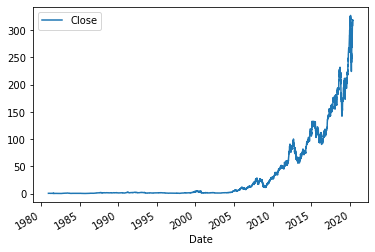

In [3]:
data.plot(y=target)

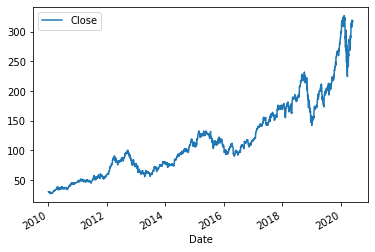

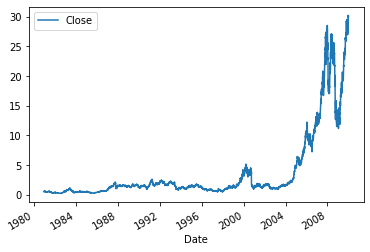

In [4]:
data[data.index > target_year].plot(y=target)
data[data.index <= target_year].plot(y=target)

## data prep

### cut time series and target col

In [5]:
data_past_2010 = data[data.index > target_year][target].copy()

### provide data sets for different models

1. Total share value (day-wise)
2. Total share value (month-wise)
3. diff share value (day-wise)
4. diff share value (month-wise)
5. share value trend (day-wise)
6. share value trand (month-wise)
---------------------------------------------


1. Total share value (day-wise)
2. Total share value (month-wise)

In [6]:
TSV_day = data_past_2010.copy()
TSV_month = data_past_2010.resample("m").mean().copy()

In [7]:
TSV_month

Date
2010-01-31     29.673609
2010-02-28     28.399398
2010-03-31     31.915838
2010-04-30     35.878368
2010-05-31     35.923071
                 ...    
2020-01-31    311.916191
2020-02-29    311.270522
2020-03-31    262.444092
2020-04-30    272.386188
2020-05-31    309.985503
Freq: M, Name: Close, Length: 125, dtype: float64

3. diff share value (day-wise)
4. diff share value (month-wise)

In [8]:
DSV_day = data_past_2010.diff().fillna(0).copy()
DSV_month = data_past_2010.diff().resample("m").mean().copy()

In [9]:
DSV_month

Date
2010-01-31   -0.174206
2010-02-28    0.094436
2010-03-31    0.188696
2010-04-30    0.177483
2010-05-31   -0.030071
                ...   
2020-01-31    0.755239
2020-02-29   -1.902633
2020-03-31   -0.866818
2020-04-30    1.881428
2020-05-31    1.207001
Freq: M, Name: Close, Length: 125, dtype: float64

5. share value trend (day-wise)
6. share value trand (month-wise)

In [10]:
SVT_day = data_past_2010.diff().fillna(0).apply(lambda x: 1 if x>=0 else 0).copy()
SVT_month = data_past_2010.diff().resample("m").mean().apply(lambda x: 1 if x>=0 else 0).copy()

In [11]:
SVT_day

Date
2010-01-04    1
2010-01-05    1
2010-01-06    0
2010-01-07    0
2010-01-08    1
             ..
2020-05-22    1
2020-05-26    0
2020-05-27    1
2020-05-28    1
2020-05-29    0
Name: Close, Length: 2619, dtype: int64

### train test split (keep order of sequence!)

In [12]:

def train_test_split(data, train_size):
    
    train = data.iloc[:train_size]
    test = data.iloc[train_size:]
    
    return train, test


train_size_day = int(len(data_past_2010) * train_ratio)
train_size_month = int(len(data_past_2010.resample("m").mean()) * train_ratio)



train_TSV_day, test_TSV_day = train_test_split(TSV_day, train_size_day)
train_TSV_month, test_TSV_month = train_test_split(TSV_month, train_size_month)

train_DSV_day, test_DSV_day = train_test_split(DSV_day, train_size_day)
train_DSV_month, test_DSV_month = train_test_split(DSV_month, train_size_month)

train_SVT_day, test_SVT_day = train_test_split(SVT_day, train_size_day)
train_SVT_month, test_SVT_month = train_test_split(SVT_month, train_size_month)


assert len(train_TSV_day) == len(train_DSV_day) == len(train_SVT_day)
assert len(test_TSV_day) == len(test_DSV_day) == len(test_SVT_day)

assert len(train_TSV_month) == len(train_DSV_month) == len(train_SVT_month)
assert len(test_TSV_month) == len(test_DSV_month) == len(test_SVT_month)


display("train_day shape: ", train_TSV_day.shape, "test_day shape: ", test_TSV_day.shape)
display("train_month shape: ", train_TSV_month.shape, "test_month shape: ", test_TSV_month.shape)



'train_day shape: '

(2357,)

'test_day shape: '

(262,)

'train_month shape: '

(112,)

'test_month shape: '

(13,)

### feature transformation: scaling/encoding

In [13]:
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler

def scale_data(train, test, scaler):
    
    ## reshape test/train from flat array [1,2,3,...] to [[1],[2],[3],...]
    
    train = np.array(train).reshape(-1,1)
    test = np.array(test).reshape(-1,1)
    
    scaler = scaler.fit(train)
    
    train = scaler.transform(train)
    test = scaler.transform(test)
       
    return train, test
    
scaler_tsv_day = StandardScaler()
scaler_dsv_day = StandardScaler()

scaler_tsv_month = StandardScaler()
scaler_dsv_month = StandardScaler()


train_TSV_day, test_TSV_day = scale_data(train_TSV_day, test_TSV_day, scaler_tsv_day)

train_DSV_day, test_DSV_day = scale_data(train_DSV_day, test_DSV_day, scaler_dsv_day)

train_TSV_month, test_TSV_month = scale_data(train_TSV_month, test_TSV_month, scaler_tsv_month)

train_DSV_month, test_DSV_month = scale_data(train_DSV_month, test_DSV_month, scaler_dsv_month)


In [14]:
print("train min", train_TSV_month.min())
print("train max ", train_TSV_month.max())
print("train std ", train_TSV_month.std())

print("test min  ", test_TSV_month.min())
print("test max  ", test_TSV_month.max())
print("test std  ", test_TSV_month.std())

train min -1.5338074296165622
train max  2.4941934414913534
train std  0.9999999999999999
test min   1.8536199025948794
test max   4.362720739416934
test std   0.9061351354694095


In [15]:
def one_hot_encoding(train, test):
    
    #coding:
    # share value increase = 1 = [0,1]
    # share value decrease = 0 = [1,0]
    
    train = train.apply(lambda x: [0,1] if x == 1 else [1,0]).to_numpy()
    test = test.apply(lambda x: [0,1] if x == 1 else [1,0]).to_numpy()

       
    return train, test


def one_hot_decoding(data):
    
    # TODO
    
    return "TODO"

In [16]:
train_SVT_day, test_SVT_day = one_hot_encoding(train_SVT_day, test_SVT_day)

train_SVT_month, test_SVT_month = one_hot_encoding(train_SVT_month, test_SVT_month)

In [17]:
test_SVT_day

array([list([1, 0]), list([1, 0]), list([1, 0]), list([0, 1]),
       list([1, 0]), list([1, 0]), list([1, 0]), list([1, 0]),
       list([1, 0]), list([0, 1]), list([1, 0]), list([1, 0]),
       list([0, 1]), list([0, 1]), list([0, 1]), list([0, 1]),
       list([0, 1]), list([0, 1]), list([1, 0]), list([1, 0]),
       list([1, 0]), list([0, 1]), list([0, 1]), list([1, 0]),
       list([0, 1]), list([1, 0]), list([1, 0]), list([1, 0]),
       list([0, 1]), list([1, 0]), list([1, 0]), list([0, 1]),
       list([0, 1]), list([0, 1]), list([1, 0]), list([1, 0]),
       list([0, 1]), list([0, 1]), list([1, 0]), list([0, 1]),
       list([0, 1]), list([1, 0]), list([1, 0]), list([0, 1]),
       list([1, 0]), list([0, 1]), list([0, 1]), list([1, 0]),
       list([1, 0]), list([0, 1]), list([0, 1]), list([1, 0]),
       list([0, 1]), list([1, 0]), list([1, 0]), list([1, 0]),
       list([0, 1]), list([0, 1]), list([0, 1]), list([1, 0]),
       list([1, 0]), list([0, 1]), list([1, 0]), list([

### create sequences (f.e. 30 days or 2 month)

In [21]:
train, test = train_TSV_day.copy(), test_TSV_day.copy()

In [23]:
print(train.shape, test.shape)

(2357, 1) (262, 1)


In [27]:
x_train_seq, y_train_seq, x_test_seq, y_test_seq = create_sequences(train, test)

In [33]:
x_test_seq.shape

(232, 30, 1)

In [25]:

def create_sequences(train, test, TIME_STEPS=30):
    
    X_seq_train, Y_seq_train = [], []
    X_seq_test, Y_seq_test = [], []

    for i in range(len(train) - TIME_STEPS):
        seq_x = train[i: (i + TIME_STEPS)]
        seq_y = train[i + TIME_STEPS]

        X_seq_train.append(seq_x)
        Y_seq_train.append(seq_y)
        
    for i in range(len(test) - TIME_STEPS):
        seq_x = test[i: (i + TIME_STEPS)]
        seq_y = test[i + TIME_STEPS]

        X_seq_test.append(seq_x)
        Y_seq_test.append(seq_y)
    
    return np.array(X_seq_train), np.array(Y_seq_train), np.array(X_seq_test), np.array(Y_seq_test)



In [34]:


x_train_TSV_day, y_train_TSV_day, x_test_TSV_day, y_test_TSV_day = create_sequences(train_TSV_day, test_TSV_day, TIME_STEPS_DAYS)
x_train_DSV_day, y_train_DSV_day, x_test_DSV_day, y_test_DSV_day = create_sequences(train_DSV_day, test_DSV_day, TIME_STEPS_DAYS)
x_train_SVT_day, y_train_SVT_day, x_test_SVT_day, y_test_SVT_day = create_sequences(train_SVT_day, test_SVT_day, TIME_STEPS_DAYS)

x_train_TSV_month, y_train_TSV_month, x_test_TSV_month, y_test_TSV_month = create_sequences(train_TSV_month, test_TSV_month, TIME_STEPS_MONTH)
x_train_DSV_month, y_train_DSV_month, x_test_DSV_month, y_test_DSV_month = create_sequences(train_DSV_month, test_DSV_month, TIME_STEPS_MONTH)
x_train_SVT_month, y_train_SVT_month, x_test_SVT_month, y_test_SVT_month = create_sequences(train_SVT_month, test_SVT_month, TIME_STEPS_MONTH)




In [35]:
print("x and y train (day) shape:   ", x_train_TSV_day.shape, y_train_TSV_day.shape)
print("x and y train (day) shape:   ", x_test_TSV_day.shape, y_test_TSV_day.shape)

print("x and y train (month) shape: ", x_train_TSV_month.shape, y_train_TSV_month.shape)
print("x and y train (month) shape: ", x_test_TSV_month.shape, y_test_TSV_month.shape)

x and y train (day) shape:    (2327, 30, 1) (2327, 1)
x and y train (day) shape:    (232, 30, 1) (232, 1)
x and y train (month) shape:  (108, 4, 1) (108, 1)
x and y train (month) shape:  (9, 4, 1) (9, 1)


In [36]:
assert len(x_train_TSV_day) == len(x_train_DSV_day) == len(x_train_SVT_day)
assert len(x_test_TSV_day) == len(x_test_TSV_day) == len(x_test_TSV_day)

assert len(y_train_TSV_day) == len(y_train_DSV_day) == len(y_train_SVT_day)
assert len(y_test_TSV_day) == len(y_test_TSV_day) == len(y_test_TSV_day)

assert len(x_train_TSV_month) == len(x_train_DSV_month) == len(x_train_SVT_month)
assert len(x_test_TSV_month) == len(x_test_TSV_month) == len(x_test_TSV_month)

assert len(y_train_TSV_month) == len(y_train_DSV_month) == len(y_train_SVT_month)
assert len(y_test_TSV_month) == len(y_test_TSV_month) == len(y_test_TSV_month)


In [37]:
x_train_TSV_day[:2]

array([[[-1.4827302 ],
        [-1.48164269],
        [-1.49166559],
        [-1.4928119 ],
        [-1.4886969 ],
        [-1.49419334],
        [-1.50121821],
        [-1.49260615],
        [-1.49619207],
        [-1.50647952],
        [-1.47970277],
        [-1.48943173],
        [-1.50018948],
        [-1.53052274],
        [-1.51488582],
        [-1.50645011],
        [-1.5007479 ],
        [-1.52599629],
        [-1.54724719],
        [-1.53939935],
        [-1.53607797],
        [-1.52617263],
        [-1.54727658],
        [-1.53725368],
        [-1.54119231],
        [-1.535108  ],
        [-1.538253  ],
        [-1.52781863],
        [-1.52279249],
        [-1.51391588]],

       [[-1.48164269],
        [-1.49166559],
        [-1.4928119 ],
        [-1.4886969 ],
        [-1.49419334],
        [-1.50121821],
        [-1.49260615],
        [-1.49619207],
        [-1.50647952],
        [-1.47970277],
        [-1.48943173],
        [-1.50018948],
        [-1.53052274],
        [

In [38]:
assert x_train_TSV_day[1][TIME_STEPS_DAYS -1] == y_train_TSV_day[:1][0]

## create LSTM model

In [40]:
#x_train_TSV_day, y_train_TSV_day, x_test_TSV_day, y_test_TSV_day

batch_size = 32

model = keras.Sequential()

model.add(keras.layers.LSTM(
    units=64,
    batch_input_shape=(batch_size, x_train_TSV_day.shape[1], x_train_TSV_day.shape[2])
))

#model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(1))


model.compile(loss="mse", optimizer="adam")


## train model

In [41]:
epochs = 10
batch_size = 32
validation_split = 0.1

train_loss = []
test_loss = []



for i in range(epochs):
    print("Epoch: ", i)
    history = model.fit(x_train_TSV_day, y_train_TSV_day, epochs=1, batch_size=batch_size, validation_split=validation_split, shuffle=False)
    train_loss.append(history.history["loss"][0])
    test_loss.append(history.history["val_loss"][0])
    model.reset_states() # assumption: stateless
    



Epoch:  0
Train on 2094 samples, validate on 233 samples
2094/2094 [==============================] - 10s 5ms/sample - loss: 0.2604 - val_loss: 0.1121
Epoch:  1
Train on 2094 samples, validate on 233 samples
2094/2094 [==============================] - 5s 2ms/sample - loss: 0.0868 - val_loss: 0.1166
Epoch:  2
Train on 2094 samples, validate on 233 samples
2094/2094 [==============================] - 5s 2ms/sample - loss: 0.0563 - val_loss: 0.0293
Epoch:  3
Train on 2094 samples, validate on 233 samples
2094/2094 [==============================] - 5s 2ms/sample - loss: 0.0145 - val_loss: 0.0204
Epoch:  4
Train on 2094 samples, validate on 233 samples
2094/2094 [==============================] - 5s 2ms/sample - loss: 0.0115 - val_loss: 0.0226
Epoch:  5
Train on 2094 samples, validate on 233 samples
2094/2094 [==============================] - 5s 2ms/sample - loss: 0.0049 - val_loss: 0.0223
Epoch:  6
Train on 2094 samples, validate on 233 samples
2094/2094 [==============================]

## validate model

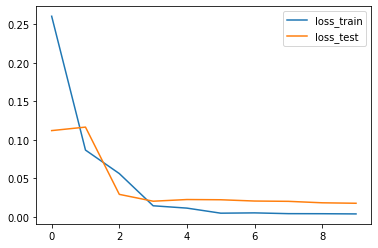

In [42]:

pd_losses = pd.DataFrame({"loss_train": train_loss, "loss_test": test_loss})

pd_losses.plot(legend=True)

## make prediction

In [51]:
y_test_TSV_day_pred = model.predict(x_test_TSV_day)

In [52]:
y_test_TSV_day_pred

array([[1.9479784],
       [1.9403627],
       [1.939074 ],
       [1.9425895],
       [1.9520882],
       [1.9645611],
       [1.9713336],
       [1.9777583],
       [1.9857612],
       [1.9905168],
       [1.9961189],
       [2.0043063],
       [2.0114796],
       [2.015814 ],
       [2.022527 ],
       [2.0238369],
       [2.030937 ],
       [2.0418737],
       [2.054104 ],
       [2.0641418],
       [2.0739608],
       [2.0855796],
       [2.0949633],
       [2.109592 ],
       [2.117233 ],
       [2.114383 ],
       [2.0871654],
       [2.0559056],
       [2.0239413],
       [2.0000925],
       [1.9773358],
       [1.9585818],
       [1.9596832],
       [1.9600418],
       [1.9629109],
       [1.9761916],
       [1.9999393],
       [2.0278027],
       [2.0606954],
       [2.0934727],
       [2.10761  ],
       [2.1179912],
       [2.1177552],
       [2.1129081],
       [2.109717 ],
       [2.105622 ],
       [2.0963018],
       [2.091945 ],
       [2.0964322],
       [2.105251 ],


In [53]:
y_test_TSV_day

array([[1.96042019],
       [2.03510718],
       [2.05938541],
       [2.09395141],
       [2.09024776],
       [2.0036276 ],
       [2.028729  ],
       [2.06967286],
       [2.0392221 ],
       [2.07111325],
       [2.11041139],
       [2.09580307],
       [2.07214206],
       [2.11967003],
       [2.05650493],
       [2.15176681],
       [2.18509804],
       [2.18160035],
       [2.14765189],
       [2.16246584],
       [2.20238089],
       [2.18386361],
       [2.27151255],
       [2.17666227],
       [2.0859272 ],
       [1.86618712],
       [1.94149133],
       [1.98346398],
       [2.07378778],
       [2.02358528],
       [2.01309189],
       [2.18777288],
       [2.05979699],
       [2.03901645],
       [2.13695286],
       [2.21616634],
       [2.21637199],
       [2.26328272],
       [2.2595794 ],
       [2.05753373],
       [2.13674722],
       [2.08880768],
       [2.11699519],
       [2.18859575],
       [2.18304074],
       [2.12049288],
       [2.19229938],
       [2.276

In [54]:
x_pred_inverse_scaled = scaler_tsv_day.inverse_transform(y_test_TSV_day_pred)
x_true_inverse_scaled = scaler_tsv_day.inverse_transform(y_test_TSV_day)

In [55]:
a = pd.DataFrame({"true": np.array(x_true_inverse_scaled).flatten(), "pred": np.array(x_pred_inverse_scaled).flatten()})

In [56]:
a["diff"] = a["true"] - a["pred"]

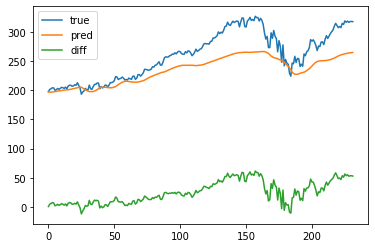

In [57]:
ax1 = a["true"].plot(legend=True)
ax2 = a["pred"].plot(legend=True,ax=ax1)
a["diff"].plot(legend=True, ax=ax2)